# Paper replication

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from IPython.display import clear_output
from tqdm import tqdm

from ca_funcs import make_glider

from nni.compression.torch import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
import paper_replication as pr

## Define CAs and training data

In [ ]:
for i, ca in enumerate(pr.sample_CAs(rng=np.random.default_rng(0))):
    X_test = torch.from_numpy(make_glider(10).reshape(1, 10, 10)).float()
    Y_test = ca(X_test).float()

    plt.figure(figsize=(12,4))
    plt.suptitle(i)

    plt.subplot(1,2,1)
    plt.imshow(X_test[0])
    plt.axis('off')
    plt.title("Input")

    plt.subplot(1,2,2)
    plt.imshow(Y_test[0])
    plt.axis('off')
    plt.title("Output")

    plt.show()
    plt.close()
    clear_output(wait=True)

## Find entropy of the training CA

In [ ]:
entropies = [pr.ca_entropy(a) for a in tqdm(pr.sample_CAs(rng=np.random.default_rng(0)))]
plt.plot(entropies)

## Training

In [ ]:
ca = list(pr.sample_CAs(rng=rng))[24]

layer_dims = [100] + [100] * 11  # neighborhood conv + mlpconv layers
rng = np.random.default_rng(0)

model, optimizer, losses = pr.train(
    100
    ca,
    layer_dims,
    rng,
    train_noise=0.5
)

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.loglog();

In [ ]:
x = np.random.default_rng().choice([0, 1], size=100)
# x = make_glider(10)
X_test = torch.from_numpy(x.reshape(1, 10, 10)).float()
Y_test = ca(X_test).float()

if torch.cuda.is_available():
    X_test = X_test.cuda()
Y_pred = model(X_test)


if torch.cuda.is_available():
    X_test = X_test.cpu()
    Y_pred = Y_pred.cpu()

X_test = X_test.detach().numpy()
Y_test = Y_test.detach().numpy()
Y_pred = Y_pred.detach().numpy()

plt.figure(figsize=(12, 4))

plt.subplot(141)
plt.imshow(X_test[0])
plt.axis('off')
plt.title("Input")

plt.subplot(142)
plt.imshow(Y_test[0])
plt.axis('off')
plt.title("Expected Output")

plt.subplot(143)
plt.imshow(Y_pred[0], vmin=0, vmax=1)
plt.axis('off')
plt.title("Observed Output")

plt.subplot(144)
plt.imshow((Y_pred[0] - Y_test[0]) ** 2)
plt.axis('off')
plt.title("Normalised Diff")

print('max loss:', ((Y_pred[0] - Y_test[0]) ** 2).max())

## Find model entropies

In [ ]:
pr.ca_entropy(ca)

In [ ]:
pr.calculate_entropies(model, layer_dims)

## Compression

### Level Pruner

In [ ]:
config_list = [{ 'sparsity': 0.1, 'op_types': ['default'] }]
m = pr.prune_model_and_test(model, optimizer, LevelPruner, config_list)
pr.display_test(m, ca)

### FPGM Pruner

In [ ]:
config_list = [{ 'sparsity': 0.1, 'op_types': ['Conv2d'] }]
m = pr.prune_model_and_test(model, optimizer, FPGMPruner, config_list)
pr.display_test(m, ca)

### L1 Pruner

In [ ]:
config_list = [{ 'sparsity': 0.1, 'op_types': ['Conv2d'] }]
m = pr.prune_model_and_test(model, optimizer, L1FilterPruner, config_list)
pr.display_test(m, ca)

### L2 Pruner

In [ ]:
config_list = [{ 'sparsity': 0.1, 'op_types': ['Conv2d'] }]
m = pr.prune_model_and_test(model, optimizer, L2FilterPruner, config_list)
pr.display_test(m, ca)

### LotteryTicket Pruner

In [ ]:
config_list = [{
    'prune_iterations': 50,
    'sparsity': 0.1,
    'op_types': ['default']
}]
m = pr.prune_model_and_test(model, optimizer, LotteryTicketPruner, config_list)
pr.display_test(m, ca)

## LMC Complexity

In [ ]:
lmcs = [pr.ca_lmc(a) for a in tqdm(pr.sample_CAs(np.random.default_rng(0)))]
plt.plot(lmcs)

In [ ]:
pr.ca_lmc(ca)

In [ ]:
pr.model_lmc(model, layer_dims)

## Collecting stats

In [3]:
cas = np.array([ca for ca in pr.sample_CAs(rng=np.random.default_rng(0))])
ca_entropies = np.array([pr.ca_entropy(ca) for ca in cas])
ca_lmcs = np.array([pr.ca_lmc(ca) for ca in cas])

In [4]:
i_test = np.r_[0:8:2, 8:128:16, 128:256:32]
i_test = np.sort(np.r_[i_test, 511 - i_test, 255])

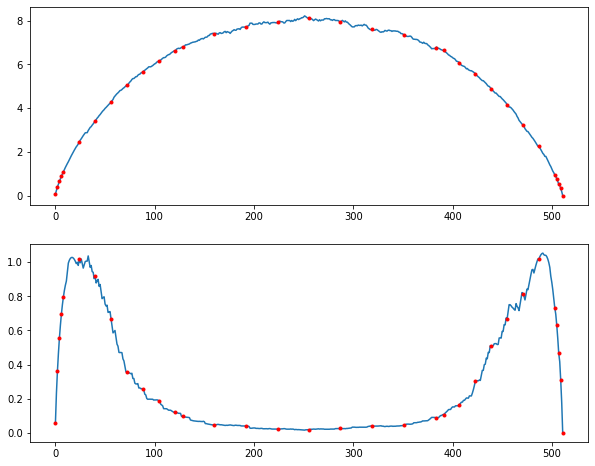

In [5]:
plt.subplot(211)
plt.plot(ca_entropies)
plt.plot(i_test, ca_entropies[i_test], 'r.')
plt.subplot(212)
plt.plot(ca_lmcs)
plt.plot(i_test, ca_lmcs[i_test], 'r.')
plt.show()

In [6]:
%%time
pr.collect_stats(i_test, [0.01, 0.02, 0.05, 0.1, 0.2], 0, 60)


CPU times: user 10h 10min 40s, sys: 11min 45s, total: 10h 22min 26s
Wall time: 6h 10min 31s
